<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY" data-toc-modified-id="IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY</a></span><ul class="toc-item"><li><span><a href="#Air-quality-Data-Exploration-and-Cleanup" data-toc-modified-id="Air-quality-Data-Exploration-and-Cleanup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Air quality Data Exploration and Cleanup</a></span><ul class="toc-item"><li><span><a href="#Import-datasets-and-overview-of-the-air-quality-data" data-toc-modified-id="Import-datasets-and-overview-of-the-air-quality-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Import datasets and overview of the air quality data</a></span></li><li><span><a href="#Slice-and-dice-the-data-to-clean-up" data-toc-modified-id="Slice-and-dice-the-data-to-clean-up-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Slice and dice the data to clean up</a></span></li><li><span><a href="#Explore-the-data-through-graphs" data-toc-modified-id="Explore-the-data-through-graphs-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Explore the data through graphs</a></span></li></ul></li><li><span><a href="#COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP</a></span></li><li><span><a href="#COVID-19-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-DATA-EXPLORATION-AND-CLEAN-UP-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>COVID-19 DATA EXPLORATION AND CLEAN UP</a></span></li></ul></li></ul></div>

# IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY

## Air quality Data Exploration and Cleanup

In [139]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint
from scipy.stats import linregress

# Import API key
from config import api_key

"https://aqicn.org/data-platform/covid19/
With the COVID-19 spreading out all over the world, the World Air Quality Index project team saw a surge in requests for global data covering the whole world map. As a result, the WAQI project is now providing a new dedicated data-set, updated 3 times a day, and covering about 380 major cities in the world, from January 2020 until now.

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation."

### Import datasets and overview of the air quality data

In [2]:
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

In [3]:
airdf_2019_2020 = pd.concat(df_list, ignore_index=True)

In [4]:
airdf_2019_2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,31/05/2020,IR,Isfahan,temperature,120,17.5,35.0,27.5,331.51
1,13/06/2020,IR,Isfahan,temperature,144,16.0,36.5,27.5,488.74
2,3/07/2020,IR,Isfahan,temperature,67,19.0,33.0,24.0,128.08
3,28/03/2020,IR,Isfahan,temperature,240,3.0,14.0,9.5,136.68
4,23/04/2020,IR,Isfahan,temperature,168,6.0,25.5,16.0,400.79


### Slice and dice the data to clean up

In [5]:
# Display an overview of the Specie column
airdf_2019_2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1'], dtype=object)

In [6]:
airdf_2019_2020["Specie"].value_counts()

temperature      310236
humidity         310145
pressure         308517
pm25             270688
no2              266793
pm10             264859
wind-speed       263292
o3               250438
so2              226576
dew              226147
co               203776
wind-gust        172805
wind speed        47002
wind gust         29576
precipitation     26825
wd                25720
aqi                8267
uvi                5632
pol                3790
pm1                1380
mepaqi              564
neph                440
Name: Specie, dtype: int64

> We understand that "Air movements influence the fate of air pollutants. So any study of air pollution should include a study of the local weather patterns (meteorology). If the air is calm and pollutants cannot disperse, then the concentration of these pollutants will build up. On the other hand, when strong, turbulent winds blow, pollutants disperse quickly, resulting in lower pollutant concentrations." https://www.qld.gov.au/environment/pollution/monitoring/air/air-monitoring/meteorology-influence/meteorology-factors#:~:text=Meteorological%20factors-,Meteorological%20factors,these%20pollutants%20will%20build%20up.
Hence the Meteorology parameters like temperature, humidity, pressure, wind speed, to name a few, should have some sorts of correlations with the air quality.
(http://www.bom.gov.au/vic/observations/melbourne.shtml)

> However, due to the scope of our project, we'll only focus on air pollutant parameters to assess their changes before COVID-19 and 6 months into the pandemic. We're not trying to explain the causes of air quality change. Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**.
https://aqicn.org/publishingdata/

> We'll also remove species with the least number of available data points  including **pol, pm1, mepaqi, neph**.

In [7]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "uvi", "pol", "pm1", "mepaqi", "neph"]

clean_airdf = airdf_2019_2020[~airdf_2019_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [8]:
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,24/02/2020,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,7/05/2020,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,28/05/2020,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,20/02/2020,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,23/02/2020,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [9]:
clean_airdf["Specie"].value_counts()

pm25    270688
no2     266793
pm10    264859
o3      250438
so2     226576
co      203776
aqi       8267
Name: Specie, dtype: int64

More about AQI:
https://www.airnow.gov/aqi/aqi-basics/
https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
"Five major pollutants:
EPA establishes an AQI for five major air pollutants regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:

* Ground-level ozone **o3** (ppm - parts per million)
* Particulate Matter - including PM2.5 **pm25** and PM10 **pm10** (μg/m3)
* Carbon Monoxide **co** (ppm)
* Sulfur Dioxide **so2** (ppb - parts per billion)
* Nitrogen Dioxide **no2** (ppb)

https://en.wikipedia.org/wiki/Air_pollution

"https://waqi.info/
The Air Quality Index is based on measurement of particulate matter (PM2.5 and PM10), Ozone (O3), Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2) and Carbon Monoxide (CO) emissions. Most of the stations on the map are monitoring both PM2.5 and PM10 data, but there are few exceptions where only PM10 is available.

All measurements are based on hourly readings: For instance, an AQI reported at 8AM means that the measurement was done from 7AM to 8AM.
More details https://aqicn.org/faq/


https://www.weatherbit.io/api/airquality-history#:~:text=Air%20Quality%20API%20(Historical),an%20air%20quality%20index%20score.

aqi: Air Quality Index [US - EPA standard 0 - +500]
o3: Concentration of surface O3 (µg/m³)
so2: Concentration of surface SO2 (µg/m³)
no2: Concentration of surface NO2 (µg/m³)
co: Concentration of carbon monoxide (µg/m³)
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)
pm10: Concentration of particulate matter < 10 microns (µg/m³)

Some good info on air pollution impacts https://ourworldindata.org/air-pollution
https://www.who.int/health-topics/air-pollution#tab=tab_1
https://www.epa.vic.gov.au/for-community/airwatch
https://www.kaggle.com/frtgnn/clean-air-india-s-air-quality/data

In [10]:
clean_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491397 entries, 0 to 1491396
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Date      1491397 non-null  object 
 1   Country   1491397 non-null  object 
 2   City      1491397 non-null  object 
 3   Specie    1491397 non-null  object 
 4   count     1491397 non-null  int64  
 5   min       1491397 non-null  float64
 6   max       1491397 non-null  float64
 7   median    1491397 non-null  float64
 8   variance  1491397 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 102.4+ MB


We can see that the Date column is of generic object type. Since we want to perform some time related analysis on this data, we need to convert it to a datetime format. Let’s use to_datetime() function to convert the Date column into a datetime object. 

In [11]:
clean_airdf["Date"] = pd.to_datetime(clean_airdf["Date"], format="%d/%m/%Y")

In [12]:
clean_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491397 entries, 0 to 1491396
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Date      1491397 non-null  datetime64[ns]
 1   Country   1491397 non-null  object        
 2   City      1491397 non-null  object        
 3   Specie    1491397 non-null  object        
 4   count     1491397 non-null  int64         
 5   min       1491397 non-null  float64       
 6   max       1491397 non-null  float64       
 7   median    1491397 non-null  float64       
 8   variance  1491397 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 102.4+ MB


In [13]:
# Find the earliest date the air quality dataset covers:
starting_date = clean_airdf["Date"].min()
starting_date

Timestamp('2018-12-31 00:00:00')

In [14]:
# Find the latest date the air quality dataset covers:
clean_airdf["Date"].max()

Timestamp('2020-07-03 00:00:00')

In [15]:
# Display an overview of the Country column
clean_airdf["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'MY', 'NL', 'NZ', 'UG', 'VN',
       'ET', 'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR',
       'IN', 'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [16]:
country_airdata_df = pd.DataFrame(clean_airdf["Country"].unique(), columns=["country_code"])
country_airdata_df

,country_code
0,IR
1,TJ
2,BR
3,CN
4,DK
...,...
90,CW
91,GB
92,NP
93,PT


There are 95 countries in the dataframe, including Australia (AU)....

In [17]:
# Display an overview of the City column
clean_airdf["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [18]:
clean_airdf["City"].value_counts()

London          5075
Shijiazhuang    3612
Qinhuangdao     3502
Anyang          3482
Beijing         3443
                ... 
Almaty           132
Conakry          115
Abidjan          115
Accra             97
Zamboanga         60
Name: City, Length: 615, dtype: int64

There are 615 cities in our dataframe. Let's see what cities in Australia covered in the dataset.

In [19]:
clean_airdf.loc[clean_airdf["Country"]=="AU", "City"].value_counts()

Sydney        3364
Brisbane      3348
Melbourne     3284
Wollongong    3253
Darwin        3208
Adelaide      3177
Perth         3082
Newcastle     2871
Hobart        1126
Launceston    1126
Canberra      1093
Name: City, dtype: int64

In [20]:
au_cities_list = ["Sydney", "Melbourne", "Perth"]

**Let's explore resampled PM2.5 median values on weekly basis in Melbourne, Victoria**

In [21]:
vic_air_df = clean_airdf.loc[(clean_airdf["Country"] == "AU") & (
    clean_airdf["City"] == "Melbourne")].sort_values("Date").set_index("Date")
vic_air_df

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
2018-12-31,AU,Melbourne,pm10,140,2.0,31.0,18.0,505.25
2018-12-31,AU,Melbourne,so2,33,1.5,2.9,1.5,3.01
2018-12-31,AU,Melbourne,o3,132,7.3,28.1,12.1,332.50
2018-12-31,AU,Melbourne,no2,116,1.0,5.6,2.8,18.30
...,...,...,...,...,...,...,...,...
2020-07-03,AU,Melbourne,pm10,88,3.0,33.0,8.0,314.86
2020-07-03,AU,Melbourne,pm25,118,1.0,45.0,17.0,1002.08
2020-07-03,AU,Melbourne,o3,80,6.4,18.4,12.8,78.87


In [22]:
vic_air_df["Specie"].value_counts()

o3      564
pm10    564
pm25    563
no2     561
co      544
so2     488
Name: Specie, dtype: int64

In [23]:
pm25_vic_air_df = vic_air_df[vic_air_df["Specie"]=="pm25"]
pm25_vic_air_df

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
2019-01-01,AU,Melbourne,pm25,161,1.0,53.0,27.0,1398.93
2019-01-02,AU,Melbourne,pm25,141,9.0,35.0,24.0,405.95
2019-01-03,AU,Melbourne,pm25,183,1.0,54.0,25.0,1325.54
2019-01-04,AU,Melbourne,pm25,192,33.0,60.0,51.0,604.15
...,...,...,...,...,...,...,...,...
2020-06-29,AU,Melbourne,pm25,186,4.0,158.0,60.0,9876.10
2020-06-30,AU,Melbourne,pm25,185,1.0,67.0,25.0,2782.67
2020-07-01,AU,Melbourne,pm25,181,2.0,55.0,19.0,1002.37


In [24]:
weekly_median_pm25_vic_air = pm25_vic_air_df["median"].resample("W").median().rename("pm2.5")
weekly_median_pm25_vic_air

Date
2019-01-06    27.0
2019-01-13    21.0
2019-01-20    38.0
2019-01-27    26.0
2019-02-03    19.0
              ... 
2020-06-07    25.0
2020-06-14    40.0
2020-06-21    20.0
2020-06-28    25.0
2020-07-05    19.0
Freq: W-SUN, Name: pm2.5, Length: 79, dtype: float64

In [25]:
#weekly_median_pm25_vic_air_df = weekly_median_pm25_vic_air.to_frame()
#weekly_median_pm25_vic_air_df.reset_index()

In [28]:
# Set cut-off dates for covid _data
cut_off_date = weekly_median_pm25_vic_air.tail(1).index[0]

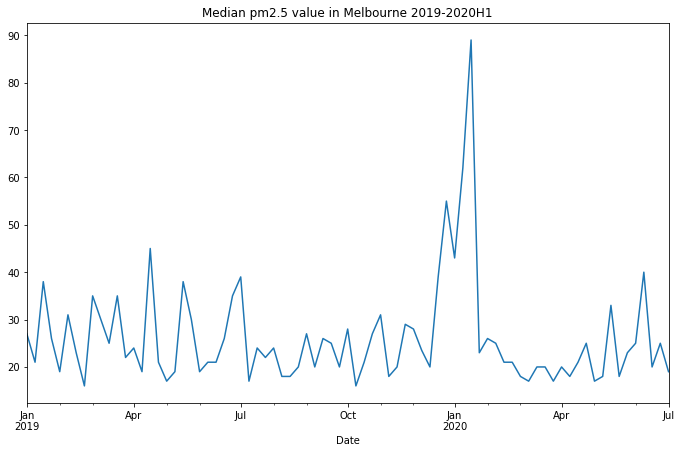

In [29]:
weekly_median_pm25_vic_air.plot(figsize=(11.5, 7), title="Median pm2.5 value in Melbourne 2019-2020H1")

In [30]:
rolling_median_pm25_vic_air = pm25_vic_air_df["median"].rolling(30, center=True).mean()

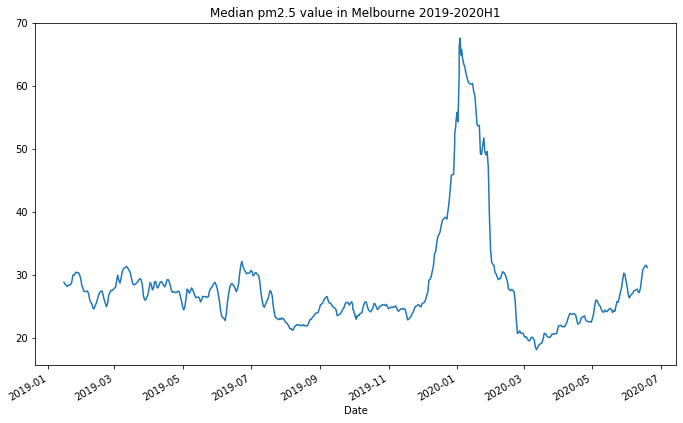

In [31]:
rolling_median_pm25_vic_air.plot(figsize=(11.5, 7), title="Median pm2.5 value in Melbourne 2019-2020H1")

**"Unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series."** (https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)

In [32]:
au_air_df = clean_airdf.loc[clean_airdf["Country"]=="AU"]
au_air_df

,Date,Country,City,Specie,count,min,max,median,variance
171565,2020-02-04,AU,Sydney,co,56,1.2,4.5,3.4,10.12
171566,2020-03-29,AU,Sydney,co,9,1.2,3.4,2.3,9.07
171567,2020-06-26,AU,Sydney,co,45,1.2,6.7,2.3,17.91
171568,2020-05-22,AU,Sydney,co,14,1.2,2.3,1.2,2.19
171569,2020-06-04,AU,Sydney,co,33,1.2,5.6,2.3,16.16
...,...,...,...,...,...,...,...,...,...
1284748,2019-12-21,AU,Wollongong,pm10,72,28.0,57.0,35.0,1107.82
1284749,2019-10-11,AU,Wollongong,pm10,65,7.0,14.0,10.0,35.66
1284750,2019-11-24,AU,Wollongong,pm10,72,12.0,31.0,18.0,236.60
1284751,2019-12-16,AU,Wollongong,pm10,48,29.0,44.0,39.0,192.61


In [33]:
five_cities_au_pm25_df = au_air_df[(au_air_df["City"].isin(au_cities_list)) & (
    au_air_df["Specie"] == "pm25")].sort_values("Date").copy()
five_cities_au_pm25_df

,Date,Country,City,Specie,count,min,max,median,variance
653866,2018-12-31,AU,Sydney,pm25,168,47.0,63.0,55.0,106.59
655757,2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
657659,2018-12-31,AU,Perth,pm25,54,33.0,44.0,37.0,68.04
653858,2019-01-01,AU,Sydney,pm25,166,37.0,69.0,56.0,546.53
655764,2019-01-01,AU,Melbourne,pm25,161,1.0,53.0,27.0,1398.93
...,...,...,...,...,...,...,...,...,...
176342,2020-07-02,AU,Melbourne,pm25,158,1.0,46.0,18.0,858.35
180172,2020-07-02,AU,Perth,pm25,81,18.0,48.0,31.0,671.00
180251,2020-07-03,AU,Perth,pm25,59,11.0,35.0,20.0,362.33
172488,2020-07-03,AU,Sydney,pm25,107,1.0,61.0,22.0,1286.52


In [34]:
five_cities_au_pm25_transposed_df = five_cities_au_pm25_df.pivot_table(index="Date", columns="City", values="median")
five_cities_au_pm25_transposed_df.head(20)

City,Melbourne,Perth,Sydney
Date,,,
2018-12-31,28.0,37.0,55.0
2019-01-01,27.0,30.0,56.0
2019-01-02,24.0,35.0,50.0
2019-01-03,25.0,25.0,45.0
2019-01-04,51.0,27.0,30.0
2019-01-05,37.0,24.0,45.0
2019-01-06,19.0,29.0,38.0
2019-01-07,13.0,41.0,27.0
2019-01-08,26.0,33.0,26.0


In [35]:
five_cities_au_pm25_transposed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 551 entries, 2018-12-31 to 2020-07-03
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Melbourne  549 non-null    float64
 1   Perth      532 non-null    float64
 2   Sydney     549 non-null    float64
dtypes: float64(3)
memory usage: 17.2 KB


In [36]:
resampled_five_cities_au_pm25_transposed_df = five_cities_au_pm25_transposed_df[au_cities_list].resample("W").median()
resampled_five_cities_au_pm25_transposed_df

City,Sydney,Melbourne,Perth
Date,,,
2019-01-06,45.0,27.0,29.0
2019-01-13,27.0,21.0,38.0
2019-01-20,41.0,38.0,34.0
2019-01-27,47.0,26.0,24.0
2019-02-03,34.0,19.0,35.0
...,...,...,...
2020-06-07,17.0,25.0,34.5
2020-06-14,22.0,40.0,27.0
2020-06-21,21.0,20.0,30.0


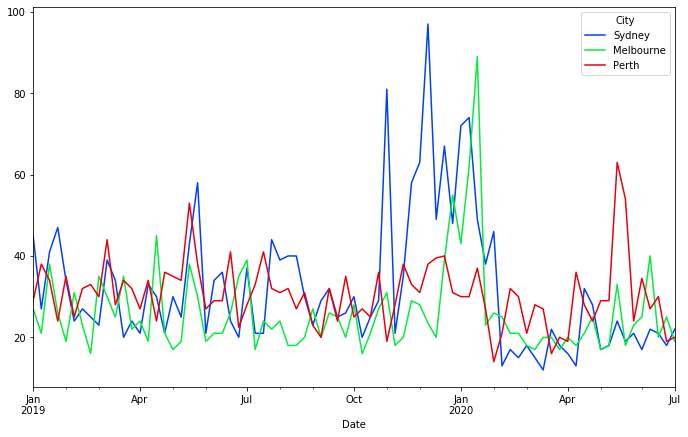

In [37]:
plt.style.use('seaborn-bright')
resampled_five_cities_au_pm25_transposed_df.plot(figsize=(11.5, 7))

In [38]:
rolling_five_cities_au_pm25 = five_cities_au_pm25_transposed_df[au_cities_list].rolling(7, center=True).mean()

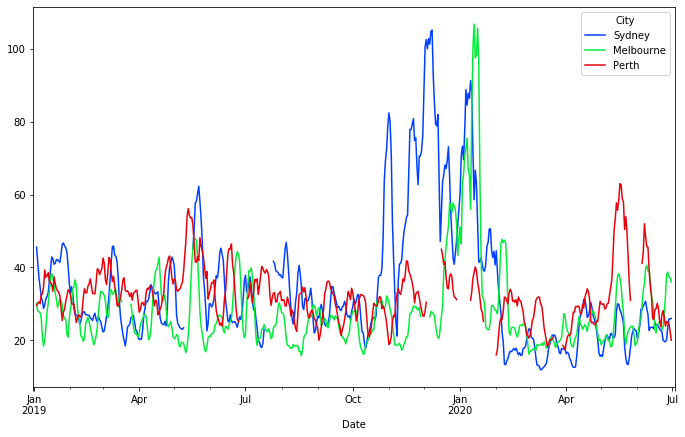

In [39]:
plt.style.use('seaborn-bright')
rolling_five_cities_au_pm25.plot(figsize=(11.5, 7))

### Explore the data through graphs

In [ ]:
unique_species = clean_airdf["Specie"].unique()
unique_species

In [ ]:
def specie_median_distribution(df, country):

    country_air_df = df[df["Country"] == country]

    fig, ax = plt.subplots(
        figsize=(10, 3*len(unique_species)),
        ncols=1,
        nrows=len(unique_species)
        )

    for index, specie in enumerate(unique_species):
        red_square=dict(markerfacecolor='r', marker='s', alpha=0.4)

        country_air_df[country_air_df["Specie"] == specie].boxplot(
            column="median",
            flierprops=red_square,
            ax=ax[index],
            vert=False)

In [ ]:
country_air_df[country_air_df["Specie"] == specie].boxplot(
            column="median",
            flierprops=red_square,
            ax=ax[index],
            vert=False)

In [ ]:
au_air_df = clean_airdf[clean_airdf["Country"]==]

In [ ]:
        ax[index].set_title=f"Distribution of median {specie} values in {country} (2019-2020H1)"

In [ ]:
specie_median_distribution(clean_airdf, "AU")

In [ ]:
variance_0_df = clean_airdf[cleanclean_airdf["variance"]==0]
variance_0_df

In [ ]:
clean_airdf[clean_airdf["Specie"]=="pm25"]

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="pm25") & (clean_airdf["median"]>=800)]

In [ ]:
specie_median_distribution(clean_airdf, "no2")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="no2") & (clean_airdf["median"]>=150)]

In [ ]:
specie_median_distribution(clean_airdf, "pm10")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="pm10") & (clean_airdf["median"]>=800)]

In [ ]:
specie_median_distribution(clean_airdf, "o3")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="o3") & (clean_airdf["median"]>=350)]

In [ ]:
specie_median_distribution(clean_airdf, "so2")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="so2") & (clean_airdf["median"]>=300)]

In [ ]:
specie_median_distribution(clean_airdf, "co")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="co") & (clean_airdf["median"]>=300)]

In [ ]:
specie_median_distribution(clean_airdf, "aqi")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="aqi") & (clean_airdf["median"]>=350)]

In [ ]:
variance_0_df["Country"].unique()

## COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP

In [40]:
au_covid_url = "https://interactive.guim.co.uk/docsdata/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE.json"
au_covid_data = requests.get(au_covid_url).json()
pprint(au_covid_data)

{'sheets': {'about': [{'about': 'This data has been compiled by Guardian '
                                'Australia from official state and territory '
                                'media releases and websites. Some death dates '
                                'and figures are from media reports. We assign '
                                'cases to the date on which they were reported '
                                'by the health department, and deaths are '
                                'assigned to the date they occured. Extended '
                                'data on testing and demographics varies '
                                'between each state and territory so may not '
                                'always be available. Please contact '
                                'australia.coronatracking@theguardian.com if '
                                'you spot an error in the data or to make a '
                                'suggestion. This data is released

                       {'Date of death': '28/04/2020',
                        'Date reported': '28/04/2020',
                        'Death No (in state)': '39',
                        'Details': '93 year old male Anglicare Sydney '
                                   'resident, Newmarch house (9th death)',
                        'Name (if known)': '',
                        'Source': 'media release (Anglicare)',
                        'State': 'NSW'},
                       {'Date of death': '28/04/2020',
                        'Date reported': '28/04/2020',
                        'Death No (in state)': '40',
                        'Details': '90 year old female Anglicare Sydney '
                                   'resident, Newmarch house (10th death)',
                        'Name (if known)': '',
                        'Source': 'media release (Anglicare)',
                        'State': 'NSW'},
                       {'Date of death': '28/04/2020',
                    

                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'SA',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '88',
                         'Time': '',
                         'Update Source': 'SA Health website',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '3',
                         'Cumulative deaths': '',
                         'Date': '04/02/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'QLD',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                        

                         'Date': '10/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'VIC',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '',
                         'Update Source': 'Victoria DHHS',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '55',
                         'Cumulative deaths': '2',
                         'Date': '10/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'NSW',
                         'Tests conduc

                         'Cumulative deaths': '6',
                         'Date': '19/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': 'press conference update, will add more '
                                  'detail shortly',
                         'Recovered (cumulative)': '',
                         'State': 'NSW',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '39089',
                         'Time': '12:30',
                         'Update Source': 'NSW Health media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '353',
                         'Cumulative deaths': '',
                         'Date': '19/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
          

                         'Time': '20:00',
                         'Update Source': 'national summary',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '62',
                         'Cumulative deaths': '',
                         'Date': '29/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'TAS',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '12:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '66',
                         'Cumulative deaths': '',
                         'Date': '29/03/2020',
            

                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '162',
                         'State': 'WA',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '14:50',
                         'Update Source': 'press conference',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '921',
                         'Cumulative deaths': '',
                         'Date': '06/04/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'QLD',
                         'Tests conducted (negative)': '',
                

                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '18:00',
                         'Update Source': 'National summary',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '180',
                         'Cumulative deaths': '',
                         'Date': '16/04/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'TAS',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '18:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count':

                         'Tests conducted (total)': '',
                         'Time': '16:22',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '205',
                         'Cumulative deaths': '',
                         'Date': '23/04/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'TAS',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '18:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '438',
                         'Cumulative deaths': '',
    

                         'Tests conducted (negative)': '232863',
                         'Tests conducted (total)': '235894',
                         'Time': '20:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '1371',
                         'Cumulative deaths': '',
                         'Date': '02/05/2020',
                         'Hospitalisations (count)': '12',
                         'Intensive care (count)': '7',
                         'Notes': '',
                         'Recovered (cumulative)': '1300',
                         'State': 'VIC',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '129000',
                         'Time': '11:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'

                        {'Cumulative case count': '3059',
                         'Cumulative deaths': '47',
                         'Date': '12/05/2020',
                         'Hospitalisations (count)': '109',
                         'Intensive care (count)': '7',
                         'Notes': '',
                         'Recovered (cumulative)': '2571',
                         'State': 'NSW',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '324000',
                         'Time': '20:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': '7'},
                        {'Cumulative case count': '107',
                         'Cumulative deaths': '',
                         'Date': '13/05/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
    

                         'Intensive care (count)': '5',
                         'Notes': '',
                         'Recovered (cumulative)': '1479',
                         'State': 'VIC',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '393000',
                         'Time': '11:40',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '107',
                         'Cumulative deaths': '',
                         'Date': '22/05/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '104',
                         'State': 'ACT',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '15146',
   

                        {'Cumulative case count': '228',
                         'Cumulative deaths': '',
                         'Date': '31/05/2020',
                         'Hospitalisations (count)': '2',
                         'Intensive care (count)': '0',
                         'Notes': '',
                         'Recovered (cumulative)': '209',
                         'State': 'TAS',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '31671',
                         'Time': '18:00',
                         'Update Source': 'Tas health website',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '3098',
                         'Cumulative deaths': '',
                         'Date': '31/05/2020',
                         'Hospitalisations (count)': '67',
                         'Intensive care (count)': '1',
                         'Notes': '',
   

                        {'Cumulative case count': '3131',
                         'Cumulative deaths': '',
                         'Date': '14/06/2020',
                         'Hospitalisations (count)': '42',
                         'Intensive care (count)': '0',
                         'Notes': '',
                         'Recovered (cumulative)': '2766',
                         'State': 'NSW',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '641442',
                         'Time': '20:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': '0'},
                        {'Cumulative case count': '1732',
                         'Cumulative deaths': '',
                         'Date': '15/06/2020',
                         'Hospitalisations (count)': '7',
                         'Intensive care (count)': '3',
                         'Notes': '',
    

                         'Recovered (cumulative)': '2784',
                         'State': 'NSW',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '830541',
                         'Time': '20:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': '0'},
                        {'Cumulative case count': '609',
                         'Cumulative deaths': '',
                         'Date': '28/06/2020',
                         'Hospitalisations (count)': '0',
                         'Intensive care (count)': '0',
                         'Notes': '',
                         'Recovered (cumulative)': '595',
                         'State': 'WA',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '11:10',
                         'Update Source': 'media release',

In [41]:
au_covid_data.keys()

dict_keys(['sheets'])

In [42]:
au_covid_data['sheets'].keys()

dict_keys(['updates', 'deaths', 'latest totals', 'locations', 'sources', 'about', 'data validation'])

In [43]:
covid_by_state = au_covid_data['sheets']['updates']
covid_by_state[50]

{'State': 'NSW',
 'Date': '26/02/2020',
 'Time': '',
 'Cumulative case count': '4',
 'Cumulative deaths': '',
 'Tests conducted (negative)': '',
 'Tests conducted (total)': '2480',
 'Hospitalisations (count)': '',
 'Intensive care (count)': '',
 'Ventilator usage (count)': '',
 'Recovered (cumulative)': '',
 'Update Source': 'NSW Health',
 'Notes': ''}

In [44]:
state_list = list()
date_list = list()
cumulative_case_count = list()
cumulative_recovered_count = list()

for element in covid_by_state:
    state_list.append(element["State"])
    date_list.append(element["Date"])
    cumulative_case_count.append(element["Cumulative case count"])
    cumulative_recovered_count.append(element["Recovered (cumulative)"])

In [45]:
au_covid_df = pd.DataFrame({
    "State": state_list,
    "Date": date_list,
    "Cumulative case count": cumulative_case_count,
    "Cumulative recovered count": cumulative_recovered_count
})
au_covid_df.head()

,State,Date,Cumulative case count,Cumulative recovered count
0,SA,23/01/2020,0,
1,VIC,25/01/2020,1,
2,NSW,25/01/2020,3,
3,NSW,27/01/2020,4,
4,QLD,28/01/2020,0,


In [46]:
au_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   State                       877 non-null    object
 1   Date                        877 non-null    object
 2   Cumulative case count       877 non-null    object
 3   Cumulative recovered count  877 non-null    object
dtypes: object(4)
memory usage: 27.5+ KB


In [47]:
au_covid_df["Cumulative case count"] = pd.to_numeric(au_covid_df["Cumulative case count"].str.replace(",", ""))

In [48]:
au_covid_df["Cumulative recovered count"] = pd.to_numeric(au_covid_df["Cumulative recovered count"].str.replace(",", ""))

In [49]:
# Convert the Date column to datetime format
au_covid_df['Date'] = pd.to_datetime(au_covid_df["Date"], format= "%d/%m/%Y", errors='coerce')

In [50]:
au_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       877 non-null    object        
 1   Date                        876 non-null    datetime64[ns]
 2   Cumulative case count       847 non-null    float64       
 3   Cumulative recovered count  439 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 27.5+ KB


In [51]:
# Find the earliest date the covid dataset covers:
au_covid_df["Date"].min()

Timestamp('2020-01-23 00:00:00')

In [52]:
# Find the latrest date the covid dataset covers:
au_covid_df["Date"].max()

Timestamp('2020-07-08 00:00:00')

In [53]:
# Set cutoff time on 5th July 2020 for the AU covid data
timebound_au_covid =  au_covid_df[au_covid_df["Date"] <= cut_off_date].copy()

In [54]:
timebound_au_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 864
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       865 non-null    object        
 1   Date                        865 non-null    datetime64[ns]
 2   Cumulative case count       836 non-null    float64       
 3   Cumulative recovered count  429 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 33.8+ KB


In [55]:
timebound_au_covid.sort_values(["State", "Date"], inplace=True, ignore_index=True)
timebound_au_covid

,State,Date,Cumulative case count,Cumulative recovered count
0,ACT,2020-03-12,1.0,NaN
1,ACT,2020-03-13,1.0,NaN
2,ACT,2020-03-14,1.0,NaN
3,ACT,2020-03-16,2.0,NaN
4,ACT,2020-03-18,3.0,NaN
...,...,...,...,...
860,WA,2020-06-30,611.0,598.0
861,WA,2020-07-01,611.0,598.0
862,WA,2020-07-03,611.0,598.0
863,WA,2020-07-04,612.0,598.0


In [56]:
cols_to_fill = ["Cumulative case count", "Cumulative recovered count"]

timebound_au_covid[cols_to_fill]= timebound_au_covid.groupby("State")[cols_to_fill].fillna(method="ffill")

In [57]:
timebound_au_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       865 non-null    object        
 1   Date                        865 non-null    datetime64[ns]
 2   Cumulative case count       865 non-null    float64       
 3   Cumulative recovered count  597 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 27.2+ KB


In [58]:
timebound_au_covid.fillna(0, inplace=True)

In [59]:
timebound_au_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       865 non-null    object        
 1   Date                        865 non-null    datetime64[ns]
 2   Cumulative case count       865 non-null    float64       
 3   Cumulative recovered count  865 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 27.2+ KB


In [60]:
timebound_au_covid[cols_to_fill] = timebound_au_covid[cols_to_fill].astype(int)

In [61]:
timebound_au_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       865 non-null    object        
 1   Date                        865 non-null    datetime64[ns]
 2   Cumulative case count       865 non-null    int32         
 3   Cumulative recovered count  865 non-null    int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 20.4+ KB


In [62]:
clean_au_covid = timebound_au_covid.copy()

In [63]:
clean_au_covid.tail(20)

,State,Date,Cumulative case count,Cumulative recovered count
845,WA,2020-06-14,602,582
846,WA,2020-06-15,602,591
847,WA,2020-06-16,602,591
848,WA,2020-06-17,602,592
849,WA,2020-06-18,603,592
850,WA,2020-06-19,603,592
851,WA,2020-06-20,604,593
852,WA,2020-06-21,605,593
853,WA,2020-06-23,607,594
854,WA,2020-06-24,607,594


In [64]:
clean_au_covid["Active_cases"] = clean_au_covid["Cumulative case count"] - clean_au_covid["Cumulative recovered count"]

In [65]:
clean_au_covid

,State,Date,Cumulative case count,Cumulative recovered count,Active_cases
0,ACT,2020-03-12,1,0,1
1,ACT,2020-03-13,1,0,1
2,ACT,2020-03-14,1,0,1
3,ACT,2020-03-16,2,0,2
4,ACT,2020-03-18,3,0,3
...,...,...,...,...,...
860,WA,2020-06-30,611,598,13
861,WA,2020-07-01,611,598,13
862,WA,2020-07-03,611,598,13
863,WA,2020-07-04,612,598,14


In [66]:
clean_au_covid['New case count'] = clean_au_covid.groupby(['State'])['Cumulative case count'].diff().fillna(0).astype(int)

In [67]:
clean_au_covid

,State,Date,Cumulative case count,Cumulative recovered count,Active_cases,New case count
0,ACT,2020-03-12,1,0,1,0
1,ACT,2020-03-13,1,0,1,0
2,ACT,2020-03-14,1,0,1,0
3,ACT,2020-03-16,2,0,2,1
4,ACT,2020-03-18,3,0,3,1
...,...,...,...,...,...,...
860,WA,2020-06-30,611,598,13,2
861,WA,2020-07-01,611,598,13,0
862,WA,2020-07-03,611,598,13,0
863,WA,2020-07-04,612,598,14,1


In [68]:
vic_covid = clean_au_covid[clean_au_covid["State"]=="VIC"].set_index("Date")
vic_covid

,State,Cumulative case count,Cumulative recovered count,Active_cases,New case count
Date,,,,,
2020-01-25,VIC,1,0,1,0
2020-01-29,VIC,2,0,2,1
2020-01-30,VIC,3,0,3,1
2020-02-01,VIC,4,0,4,1
2020-03-01,VIC,9,0,9,5
...,...,...,...,...,...
2020-07-01,VIC,2231,1839,392,72
2020-07-02,VIC,2303,1866,437,72
2020-07-03,VIC,2368,1904,464,65


Text(0.5, 0, 'Year-Month')

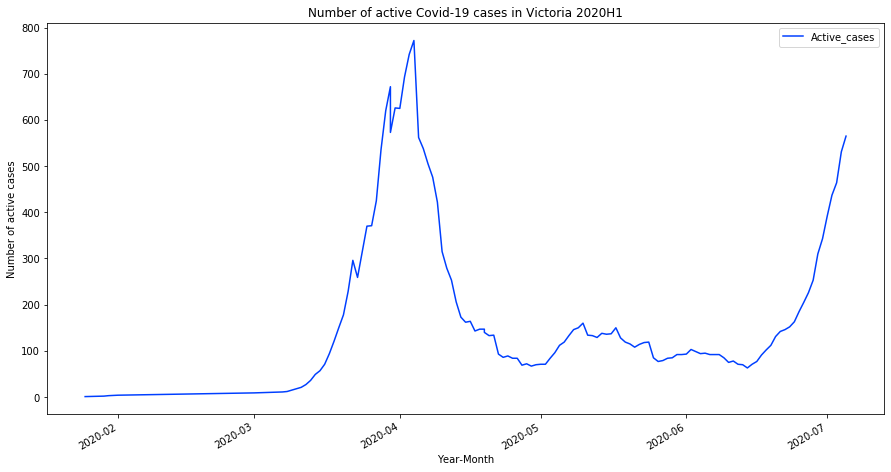

In [69]:
ax = vic_covid.plot(y="Active_cases", figsize=(15, 8), title="Number of active Covid-19 cases in Victoria 2020H1")
ax.set_ylabel("Number of active cases")
ax.set_xlabel("Year-Month")

In [70]:
weekly_active_cases_vic_covid = vic_covid["Active_cases"].resample("W").sum().to_frame()
weekly_active_cases_vic_covid

,Active_cases
Date,
2020-01-26,1
2020-02-02,9
2020-02-09,0
2020-02-16,0
2020-02-23,0
2020-03-01,9
2020-03-08,33
2020-03-15,223
2020-03-22,1139


In [71]:
# Fill in dates to 
date_range_to_fill = pd.date_range(starting_date, "2020-01-19", freq="W").to_frame(name="Active_cases")
date_range_to_fill["Active_cases"]=0
date_range_to_fill

,Active_cases
2019-01-06,0
2019-01-13,0
2019-01-20,0
2019-01-27,0
2019-02-03,0
2019-02-10,0
2019-02-17,0
2019-02-24,0
2019-03-03,0
2019-03-10,0


In [72]:
time_matching_vic_covid_weekly_cases_df = pd.concat(
    [date_range_to_fill, weekly_active_cases_vic_covid]).reset_index().rename(columns={"index": "Date"})
time_matching_vic_covid_weekly_cases_df

,Date,Active_cases
0,2019-01-06,0
1,2019-01-13,0
2,2019-01-20,0
3,2019-01-27,0
4,2019-02-03,0
...,...,...
74,2020-06-07,569
75,2020-06-14,534
76,2020-06-21,726
77,2020-06-28,1330


In [73]:
time_matching_vic_covid_weekly_cases_df.set_index("Date", inplace=True)

In [74]:
time_matching_vic_covid_weekly_cases_df

,Active_cases
Date,
2019-01-06,0
2019-01-13,0
2019-01-20,0
2019-01-27,0
2019-02-03,0
...,...
2020-06-07,569
2020-06-14,534
2020-06-21,726


## COVID-19 DATA EXPLORATION AND CLEAN UP

Covid-19 is sourced from here https://covid19api.com/

In [76]:
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

[{'Country': 'Antigua and Barbuda',
  'ISO2': 'AG',
  'Slug': 'antigua-and-barbuda'},
 {'Country': 'San Marino', 'ISO2': 'SM', 'Slug': 'san-marino'},
 {'Country': 'Serbia', 'ISO2': 'RS', 'Slug': 'serbia'},
 {'Country': 'Guernsey', 'ISO2': 'GG', 'Slug': 'guernsey'},
 {'Country': 'Montenegro', 'ISO2': 'ME', 'Slug': 'montenegro'},
 {'Country': 'Belarus', 'ISO2': 'BY', 'Slug': 'belarus'},
 {'Country': 'Cyprus', 'ISO2': 'CY', 'Slug': 'cyprus'},
 {'Country': 'Afghanistan', 'ISO2': 'AF', 'Slug': 'afghanistan'},
 {'Country': 'Kyrgyzstan', 'ISO2': 'KG', 'Slug': 'kyrgyzstan'},
 {'Country': 'Myanmar', 'ISO2': 'MM', 'Slug': 'myanmar'},
 {'Country': 'Senegal', 'ISO2': 'SN', 'Slug': 'senegal'},
 {'Country': 'Sudan', 'ISO2': 'SD', 'Slug': 'sudan'},
 {'Country': 'Barbados', 'ISO2': 'BB', 'Slug': 'barbados'},
 {'Country': 'Honduras', 'ISO2': 'HN', 'Slug': 'honduras'},
 {'Country': 'Korea (South)', 'ISO2': 'KR', 'Slug': 'korea-south'},
 {'Country': 'Niger', 'ISO2': 'NE', 'Slug': 'niger'},
 {'Country': '

In [77]:
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

,Country,Slug,ISO2
0,Antigua and Barbuda,antigua-and-barbuda,AG
1,San Marino,san-marino,SM
2,Serbia,serbia,RS
3,Guernsey,guernsey,GG
4,Montenegro,montenegro,ME
...,...,...,...
243,Mauritania,mauritania,MR
244,British Indian Ocean Territory,british-indian-ocean-territory,IO
245,Cameroon,cameroon,CM
246,"Virgin Islands, US",virgin-islands,VI


In [78]:
# Merge countries available on the air quality data and the covid data
country_covid_air_df = pd.merge(
    country_airdata_df, country_covid_df, how="left", left_on="country_code", right_on="ISO2")
country_covid_air_df

,country_code,Country,Slug,ISO2
0,IR,"Iran, Islamic Republic of",iran,IR
1,TJ,Tajikistan,tajikistan,TJ
2,BR,Brazil,brazil,BR
3,CN,China,china,CN
4,DK,Denmark,denmark,DK
...,...,...,...,...
90,CW,NaN,NaN,NaN
91,GB,United Kingdom,united-kingdom,GB
92,NP,Nepal,nepal,NP
93,PT,Portugal,portugal,PT


In [79]:
# Find the country in the country_airdata_df but not country_covid_df
country_to_remove = country_covid_air_df[country_covid_air_df["ISO2"].isna()]["country_code"].tolist()
country_to_remove

['CW']

In [80]:
final_airdf = clean_airdf[~clean_airdf["Country"].isin(country_to_remove)].copy()

In [81]:
final_airdf["Country"].nunique()

94

In [82]:
country_covid_air_df

,country_code,Country,Slug,ISO2
0,IR,"Iran, Islamic Republic of",iran,IR
1,TJ,Tajikistan,tajikistan,TJ
2,BR,Brazil,brazil,BR
3,CN,China,china,CN
4,DK,Denmark,denmark,DK
...,...,...,...,...
90,CW,NaN,NaN,NaN
91,GB,United Kingdom,united-kingdom,GB
92,NP,Nepal,nepal,NP
93,PT,Portugal,portugal,PT


In [83]:
del country_covid_air_df["ISO2"]

In [84]:
# Return a dataframe covering all countries in both the air quality data and covid-19 data.
country_covid_air_df = country_covid_air_df[~country_covid_air_df["country_code"].isin(
    country_to_remove)]
country_covid_air_df

,country_code,Country,Slug
0,IR,"Iran, Islamic Republic of",iran
1,TJ,Tajikistan,tajikistan
2,BR,Brazil,brazil
3,CN,China,china
4,DK,Denmark,denmark
...,...,...,...
89,KG,Kyrgyzstan,kyrgyzstan
91,GB,United Kingdom,united-kingdom
92,NP,Nepal,nepal
93,PT,Portugal,portugal


In [85]:
# Explore one covid API - By Country Total All Status
covid_url_example = "https://api.covid19api.com/total/country/australia"
covid_data_example = requests.get(covid_url_example).json()
pprint(covid_data_example)

[{'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-22T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-23T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-24T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-25T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 4,
  'City': '',
  'CityCode': '',
  'Confirmed': 4,
  'Country': 'Australia',
  'Co

 {'Active': 4420,
  'City': '',
  'CityCode': '',
  'Confirmed': 4862,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-01T00:00:00Z',
  'Deaths': 20,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 422},
 {'Active': 4572,
  'City': '',
  'CityCode': '',
  'Confirmed': 5116,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-02T00:00:00Z',
  'Deaths': 24,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 520},
 {'Active': 4653,
  'City': '',
  'CityCode': '',
  'Confirmed': 5330,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-03T00:00:00Z',
  'Deaths': 28,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 649},
 {'Active': 4819,
  'City': '',
  'CityCode': '',
  'Confirmed': 5550,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-04T00:00:00Z',
  'Deaths': 30,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 701},
 {'Active': 4895,
  'City': '',
  'CityCode': '',
  'Confirm

  'CityCode': '',
  'Confirmed': 7320,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-13T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6838},
 {'Active': 382,
  'City': '',
  'CityCode': '',
  'Confirmed': 7335,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-14T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6851},
 {'Active': 389,
  'City': '',
  'CityCode': '',
  'Confirmed': 7347,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-15T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6856},
 {'Active': 407,
  'City': '',
  'CityCode': '',
  'Confirmed': 7370,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-16T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6861},
 {'Active': 412,
  'City': '',
  'CityCode': '',
  'Confirmed': 7391,
  'Country': 'Aus

The above api example covers covid-19 data until 4th July 2020. It also shows the number of confirmed, active, recovered, and death cases for each chosen country over the course of the current pandemic. Hence, we'll use this api to loop through our country_covid_air_df as above.

In [86]:
slug_list = country_covid_air_df["Slug"].tolist()
len(slug_list)

94

In [87]:
base_covid_url = "https://api.covid19api.com/total/country/"
    
country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:
    
    try:
        response = requests.get(base_covid_url + slug).json()
    
        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

Beginning Data Retrieval
-----------------------------------
Processing Record 1 of Set 1 | iran
Processing Record 2 of Set 1 | tajikistan
Processing Record 3 of Set 1 | brazil
Processing Record 4 of Set 1 | china
Processing Record 5 of Set 1 | denmark
Processing Record 6 of Set 1 | spain
Processing Record 7 of Set 1 | mali
Processing Record 8 of Set 1 | slovakia
Processing Record 9 of Set 1 | kosovo
Processing Record 10 of Set 1 | chile
Processing Record 11 of Set 1 | germany
Processing Record 12 of Set 1 | kuwait
Processing Record 13 of Set 1 | myanmar
Processing Record 14 of Set 1 | philippines
Processing Record 15 of Set 1 | pakistan
Processing Record 16 of Set 1 | poland
Processing Record 17 of Set 1 | russia
Processing Record 18 of Set 1 | sweden
Processing Record 19 of Set 1 | singapore
Processing Record 20 of Set 1 | united-arab-emirates
Processing Record 21 of Set 1 | bosnia-and-herzegovina
Processing Record 22 of Set 1 | czech-republic
Processing Record 23 of Set 1 | indonesi

In [88]:
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

,Country,Date,Active cases,Confirmed cases,Recovered cases,Deaths
0,"Iran, Islamic Republic of",2020-01-22T00:00:00Z,0,0,0,0
1,"Iran, Islamic Republic of",2020-01-23T00:00:00Z,0,0,0,0
2,"Iran, Islamic Republic of",2020-01-24T00:00:00Z,0,0,0,0
3,"Iran, Islamic Republic of",2020-01-25T00:00:00Z,0,0,0,0
4,"Iran, Islamic Republic of",2020-01-26T00:00:00Z,0,0,0,0


In [89]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14952 entries, 0 to 14951
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          14952 non-null  object
 1   Date             14952 non-null  object
 2   Active cases     14952 non-null  int64 
 3   Confirmed cases  14952 non-null  int64 
 4   Recovered cases  14952 non-null  int64 
 5   Deaths           14952 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 701.0+ KB


In [90]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [91]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

Timestamp('2020-01-22 00:00:00')

In [92]:
# Find the latrest date the covid dataset covers:
covid_df["Date"].max()

Timestamp('2020-07-07 00:00:00')

In [102]:
# Set cutoff date to the latest date on the air quality data
world_covid_df = covid_df[covid_df["Date"] <= cut_off_date]

In [103]:
world_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14774 entries, 0 to 14949
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Country          14774 non-null  object        
 1   Date             14774 non-null  datetime64[ns]
 2   Active cases     14774 non-null  int64         
 3   Confirmed cases  14774 non-null  int64         
 4   Recovered cases  14774 non-null  int64         
 5   Deaths           14774 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 808.0+ KB


In [104]:
world_covid_df.tail(10)

,Country,Date,Active cases,Confirmed cases,Recovered cases,Deaths
14940,United States of America,2020-06-26,1671114,2467554,670809,125631
14941,United States of America,2020-06-27,1704831,2510259,679308,126120
14942,United States of America,2020-06-28,1737770,2549294,685164,126360
14943,United States of America,2020-06-29,1758754,2590668,705203,126711
14944,United States of America,2020-06-30,1788351,2636414,720631,127432
14945,United States of America,2020-07-01,1829489,2687588,729994,128105
14946,United States of America,2020-07-02,1829169,2739879,781970,128740
14947,United States of America,2020-07-03,1874315,2794153,790404,129434
14948,United States of America,2020-07-04,1815435,2839436,894325,129676
14949,United States of America,2020-07-05,1851925,2888635,906763,129947


,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [106]:
country_covid_air_df.head()

,country_code,Country,Slug
0,IR,"Iran, Islamic Republic of",iran
1,TJ,Tajikistan,tajikistan
2,BR,Brazil,brazil
3,CN,China,china
4,DK,Denmark,denmark


In [107]:
world_covid_countrycode = pd.merge(world_covid_df, country_covid_air_df, how="left", on="Country")
world_covid_countrycode

,Country,Date,Active cases,Confirmed cases,Recovered cases,Deaths,country_code,Slug
0,"Iran, Islamic Republic of",2020-01-22,0,0,0,0,IR,iran
1,"Iran, Islamic Republic of",2020-01-23,0,0,0,0,IR,iran
2,"Iran, Islamic Republic of",2020-01-24,0,0,0,0,IR,iran
3,"Iran, Islamic Republic of",2020-01-25,0,0,0,0,IR,iran
4,"Iran, Islamic Republic of",2020-01-26,0,0,0,0,IR,iran
...,...,...,...,...,...,...,...,...
14769,United States of America,2020-07-01,1829489,2687588,729994,128105,US,united-states
14770,United States of America,2020-07-02,1829169,2739879,781970,128740,US,united-states
14771,United States of America,2020-07-03,1874315,2794153,790404,129434,US,united-states
14772,United States of America,2020-07-04,1815435,2839436,894325,129676,US,united-states


In [110]:
clean_world_covid = world_covid_countrycode[["Date", "country_code", "Active cases"]].sort_values("Date")
clean_world_covid

,Date,country_code,Active cases
0,2020-01-22,IR,0
2656,2020-01-22,RU,0
12118,2020-01-22,GE,0
10624,2020-01-22,BG,0
4150,2020-01-22,AR,0
...,...,...,...
11785,2020-07-05,UG,48
2821,2020-07-05,RU,220143
11951,2020-07-05,VN,15
9793,2020-07-05,IT,14642


In [111]:
clean_world_covid_transposed = clean_world_covid.pivot_table(index="Date", columns="country_code", values="Active cases")
clean_world_covid_transposed

country_code,AE,AF,AR,AT,AU,BA,BD,BE,BG,BH,...,TJ,TR,TW,UA,UG,US,UZ,VN,XK,ZA
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,2,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,2,0,2,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,2,0,2,0,0
2020-01-26,0,0,0,0,4,0,0,0,0,0,...,0,0,4,0,0,5,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,10593,15411,42806,677,807,1986,85262,34734,2200,5374,...,1326,20526,2,24492,56,1829489,2908,19,1293,80559
2020-07-02,10488,15174,44370,722,832,2084,84909,34793,2281,5160,...,1316,20152,3,24866,55,1829169,3017,15,1302,83218
2020-07-03,10670,14174,46125,787,837,2221,86375,34889,2366,4997,...,1316,19992,4,25182,62,1874315,3116,15,1302,87874


In [113]:
clean_world_covid_transposed["total_active_cases"] = clean_world_covid_transposed.sum(axis=1)
clean_world_covid_transposed

country_code,AE,AF,AR,AT,AU,BA,BD,BE,BG,BH,...,TR,TW,UA,UG,US,UZ,VN,XK,ZA,total_active_cases
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1020
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,2,0,0,1212
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,2,0,0,1758
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,2,0,2,0,0,2706
2020-01-26,0,0,0,0,4,0,0,0,0,0,...,0,4,0,0,5,0,2,0,0,4018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,10593,15411,42806,677,807,1986,85262,34734,2200,5374,...,20526,2,24492,56,1829489,2908,19,1293,80559,8918866
2020-07-02,10488,15174,44370,722,832,2084,84909,34793,2281,5160,...,20152,3,24866,55,1829169,3017,15,1302,83218,8687206
2020-07-03,10670,14174,46125,787,837,2221,86375,34889,2366,4997,...,19992,4,25182,62,1874315,3116,15,1302,87874,8863678


In [130]:
total_active_world_covid = clean_world_covid_transposed["total_active_cases"].to_frame().reset_index()
total_active_world_covid

,Date,total_active_cases
0,2020-01-22,1020
1,2020-01-23,1212
2,2020-01-24,1758
3,2020-01-25,2706
4,2020-01-26,4018
...,...,...
161,2020-07-01,8918866
162,2020-07-02,8687206
163,2020-07-03,8863678
164,2020-07-04,8839114


In [142]:
final_airdf.head(10)

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67
5,2020-05-19,IR,Isfahan,pm25,168,31.0,172.0,89.0,6310.77
6,2020-05-30,IR,Isfahan,pm25,115,36.0,164.0,78.0,5630.48
7,2020-01-22,IR,Isfahan,pm25,145,59.0,141.0,91.0,4123.42
8,2020-01-23,IR,Isfahan,pm25,134,42.0,109.0,63.0,1529.14
9,2020-03-06,IR,Isfahan,pm25,94,58.0,195.0,111.0,9950.79


In [147]:
def world_air_covid_each_specie(specie):
    air_median_specie_transposed = final_airdf[final_airdf["Specie"] == specie].pivot_table(
        index="Date", columns="Country", values="median")

    air_median_specie_transposed[f"World Average {specie}"] = air_median_specie_transposed.mean(axis=1)

    final_air_median_specie_transposed = air_median_specie_transposed.iloc[:, -1].to_frame().reset_index()
    
    world_air_covid_median_specie = pd.merge(total_active_world_covid, final_air_median_specie_transposed, how="inner", on="Date")
    return world_air_covid_median_specie

In [148]:
world_air_covid_median_pm25 = world_air_covid_each_specie("pm25")
world_air_covid_median_pm25.head(10)

,Date,total_active_cases,World Average pm25
0,2020-01-22,1020,78.933646
1,2020-01-23,1212,78.279723
2,2020-01-24,1758,78.990238
3,2020-01-25,2706,78.903513
4,2020-01-26,4018,79.233584
5,2020-01-27,5564,75.705118
6,2020-01-28,10674,70.635516
7,2020-01-29,11808,67.210689
8,2020-01-30,15834,69.476015
9,2020-01-31,18974,72.024715


In [154]:
world_air_covid_median_co = world_air_covid_each_specie("co")
world_air_covid_median_co.head(10)

,Date,total_active_cases,World Average co
0,2020-01-22,1020,7.166114
1,2020-01-23,1212,6.737825
2,2020-01-24,1758,6.983667
3,2020-01-25,2706,7.022136
4,2020-01-26,4018,7.421955
5,2020-01-27,5564,8.447428
6,2020-01-28,10674,7.304592
7,2020-01-29,11808,7.239009
8,2020-01-30,15834,6.405740
9,2020-01-31,18974,5.721845


In [149]:
def linear_regression_plot(df_name, df, x, y):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(df[x], df[y])
    regress_values = slope * df[x] + intercept

    line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"

    print(f"The correlation coefficient is: {rvalue}")
    print(f"The r-squared is: {rvalue**2}")

    plt.scatter(df[x], df[y], facecolors="dodgerblue", alpha=0.5)
    plt.plot(df[x], regress_values, "b--", linewidth=1)
    plt.annotate(line_eq, (df[x].min(), df[y].quantile(
        0.25)), fontsize=15, color="blue")
    plt.title(f"{df_name}world")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(f"images/{df_name}linear.png")
    plt.show()

The correlation coefficient is: -0.8416819310654098
The r-squared is: 0.7084284730819972


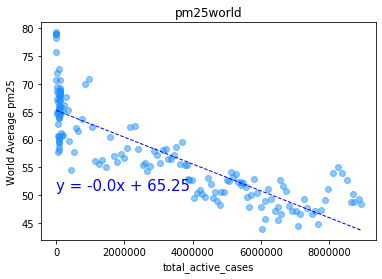

In [152]:
linear_regression_plot("pm25", world_air_covid_median_pm25, x="total_active_cases", y="World Average pm25")

The correlation coefficient is: -0.4474340695477262
The r-squared is: 0.20019724659203947


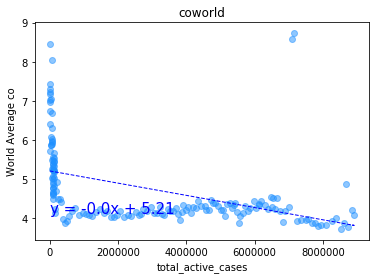

In [155]:
linear_regression_plot("co", world_air_covid_median_co, x="total_active_cases", y="World Average co")

In [ ]:
air_median_pm25_transposed = final_airdf[final_airdf["Specie"] == "pm25"].pivot_table(
    index="Date", columns="Country", values="median")
air_median_pm25_transposed

In [123]:
air_median_pm25_transposed

Country,AE,AF,AR,AT,AU,BA,BD,BE,BG,BH,...,TM,TR,TW,UA,UG,US,UZ,VN,XK,ZA
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,112.0,NaN,NaN,36.0,28.800000,76.500000,190.0,63.500000,86.0,129.0,...,NaN,109.200000,35.888889,NaN,97.0,33.107143,144.0,61.50,124.0,47.200000
2019-01-01,122.0,NaN,NaN,27.5,27.700000,74.000000,207.0,50.500000,78.0,80.0,...,NaN,88.300000,39.000000,NaN,112.0,30.642857,155.0,78.00,70.0,48.000000
2019-01-02,99.0,NaN,30.0,12.0,29.600000,155.500000,207.0,30.000000,58.0,117.0,...,NaN,109.500000,39.666667,NaN,122.0,31.160714,152.0,86.50,139.0,42.400000
2019-01-03,117.0,NaN,34.0,17.0,30.000000,62.500000,235.0,38.166667,58.0,102.0,...,NaN,97.300000,43.000000,NaN,152.0,32.839286,153.0,83.50,55.0,37.800000
2019-01-04,107.0,NaN,NaN,41.5,25.800000,107.000000,291.0,74.333333,62.0,80.0,...,NaN,51.900000,63.777778,NaN,154.0,38.035714,97.0,100.00,68.0,42.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-29,126.0,85.0,17.0,19.0,32.700000,87.666667,85.0,17.000000,NaN,104.0,...,57.0,54.600000,27.777778,25.555556,152.0,37.944444,61.0,30.20,57.0,54.400000
2020-06-30,112.0,82.0,30.0,15.0,31.600000,33.666667,76.0,14.333333,NaN,129.0,...,53.0,44.066667,24.555556,28.625000,162.0,40.694444,87.0,34.60,49.0,62.727273
2020-07-01,102.5,76.0,21.0,21.0,32.700000,52.666667,59.0,11.666667,NaN,114.0,...,55.0,45.200000,23.888889,17.125000,157.0,37.111111,78.0,32.00,37.0,73.500000


In [124]:
air_median_pm25_transposed["Average pm25"] = final_air_median_pm25_transposed.mean(axis=1)
air_median_pm25_transposed

Country,AE,AF,AR,AT,AU,BA,BD,BE,BG,BH,...,TR,TW,UA,UG,US,UZ,VN,XK,ZA,Average pm25
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,112.0,NaN,NaN,36.0,28.800000,76.500000,190.0,63.500000,86.0,129.0,...,109.200000,35.888889,NaN,97.0,33.107143,144.0,61.50,124.0,47.200000,64.402477
2019-01-01,122.0,NaN,NaN,27.5,27.700000,74.000000,207.0,50.500000,78.0,80.0,...,88.300000,39.000000,NaN,112.0,30.642857,155.0,78.00,70.0,48.000000,65.242728
2019-01-02,99.0,NaN,30.0,12.0,29.600000,155.500000,207.0,30.000000,58.0,117.0,...,109.500000,39.666667,NaN,122.0,31.160714,152.0,86.50,139.0,42.400000,62.573236
2019-01-03,117.0,NaN,34.0,17.0,30.000000,62.500000,235.0,38.166667,58.0,102.0,...,97.300000,43.000000,NaN,152.0,32.839286,153.0,83.50,55.0,37.800000,63.338851
2019-01-04,107.0,NaN,NaN,41.5,25.800000,107.000000,291.0,74.333333,62.0,80.0,...,51.900000,63.777778,NaN,154.0,38.035714,97.0,100.00,68.0,42.800000,69.800048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-29,126.0,85.0,17.0,19.0,32.700000,87.666667,85.0,17.000000,NaN,104.0,...,54.600000,27.777778,25.555556,152.0,37.944444,61.0,30.20,57.0,54.400000,48.745721
2020-06-30,112.0,82.0,30.0,15.0,31.600000,33.666667,76.0,14.333333,NaN,129.0,...,44.066667,24.555556,28.625000,162.0,40.694444,87.0,34.60,49.0,62.727273,48.800820
2020-07-01,102.5,76.0,21.0,21.0,32.700000,52.666667,59.0,11.666667,NaN,114.0,...,45.200000,23.888889,17.125000,157.0,37.111111,78.0,32.00,37.0,73.500000,48.388605


In [146]:
final_air_median_pm25_transposed = air_median_pm25_transposed.iloc[:, -1].to_frame()
final_air_median_pm25_transposed

,Average pm25
Date,
2018-12-31,64.402477
2019-01-01,65.242728
2019-01-02,62.573236
2019-01-03,63.338851
2019-01-04,69.800048
...,...
2020-06-29,48.745721
2020-06-30,48.800820
2020-07-01,48.388605


In [132]:
world_air_covid_median_pm25 = pd.merge(total_active_world_covid, final_air_median_pm25_transposed, how="inner", on="Date")
world_air_covid_median_pm25

,Date,total_active_cases,Average pm25
0,2020-01-22,1020,78.933646
1,2020-01-23,1212,78.279723
2,2020-01-24,1758,78.990238
3,2020-01-25,2706,78.903513
4,2020-01-26,4018,79.233584
...,...,...,...
159,2020-06-29,8632776,48.745721
160,2020-06-30,8730588,48.800820
161,2020-07-01,8918866,48.388605
162,2020-07-02,8687206,50.280424


In [ ]:
# import time
# from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
# from citipy import citipy

In [ ]:
# url = "https://api.openaq.org/v1/measurements"

# data = requests.get(url).json()
# pprint(data)

In [ ]:
# len(data["results"])

In [ ]:
# data["results"][0]

In [ ]:
# Data source: https://aqicn.org/api/
# base_url = "https://api.waqi.info/feed/"
# city = "melbourne"
# url = f"{base_url}{city}/?token={api_key}"

In [ ]:
# url_2 = "https://api.covid19api.com/country/south-africa/status/confirmed/live"
# covid_data_2 = requests.get(url_2).json()
# pprint(covid_data_2[-1])